Iterations: 24
Row sums (max abs): 1.1379786002407855e-15
Off-diagonals ≥ 0?  True
Diagonal ≤ 0?       True
Shares state1 (F,B,0): 0.0 0.99 0.01
Shares state2 (F,B,0): 0.69 0.29 0.02
||Residual||_∞: 2.8919089345436078e-12


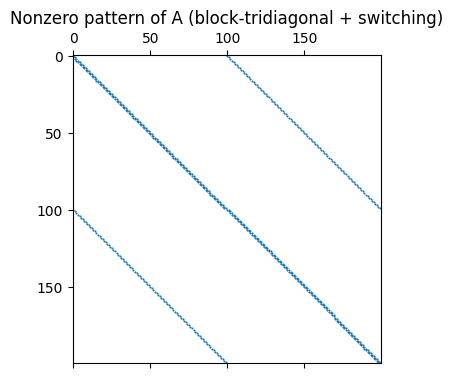

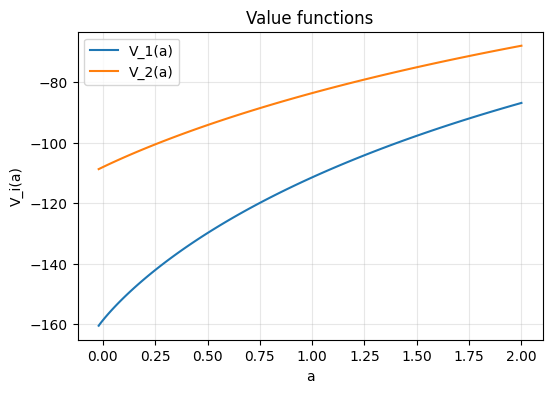

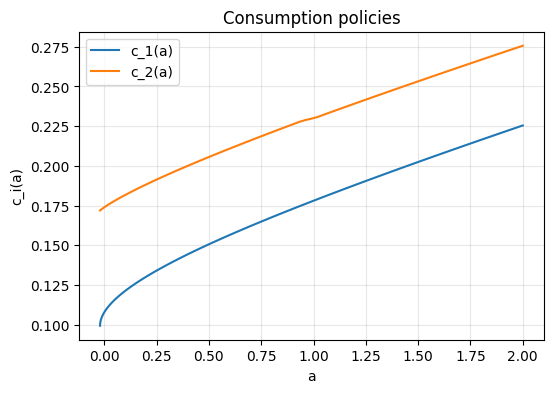

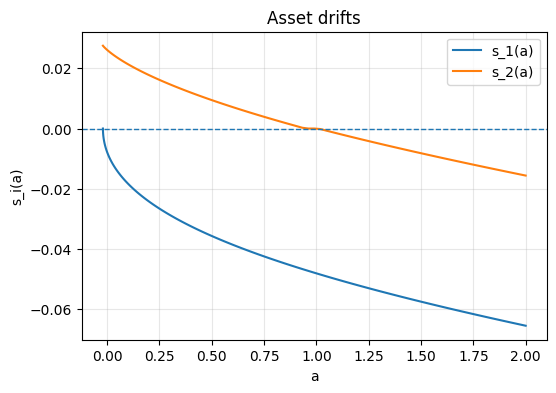


Stationary KF diagnostics:
  sum(masses) = 0.9999999999999999    (should be 1)
  ||A^T m||_∞ = 1.1015677993869667e-17
  Weighted mass from densities = 0.9999999999999999  (should be 1)
  E[a | z1] = 0.037170104288669285   E[a | z2] = 0.1786757236897546   E[a] = 0.2158458279784239


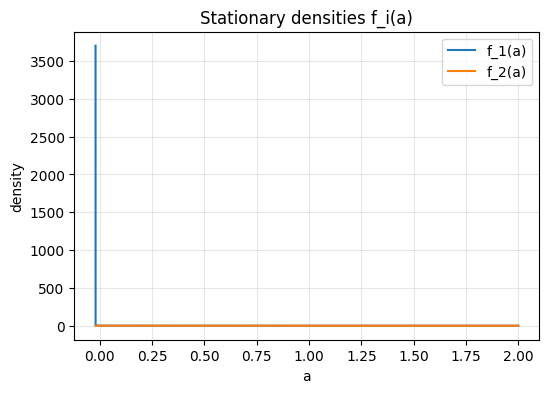

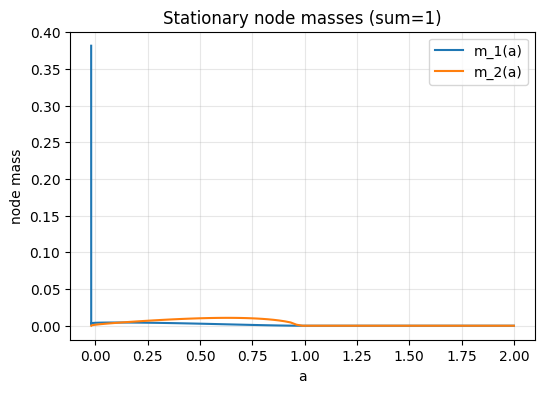

In [1]:
# Continuous-time consumption–savings HJB (1D deterministic, WITH Poisson)
# Implementation aligned with JFV slides & your MATLAB logic
# Upwind: If = (sF>0), Ib = (sB<0), I0 = ~(If|Ib)
# Per-state A via X/Y/Z: X = -s^- / Δa_i,  Z = s^+ / Δa_{i+1},  Y = -(X+Z)
# Switching is added in a separate block Λ; boundaries: X_1=0, Z_I=0.
# Stationary distribution: solve A^T m = 0 for node masses m (sum m = 1); density f = m / w

import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Parameters
# -------------------------
rho   = 0.05
r     = 0.03
z1, z2 = 0.10, 0.20          # two income levels
la1, la2 = 0.02, 0.03        # switching rates: 1->2, 2->1
I     = 100
a_min, a_max = -0.02, 2.0
Delta = 500.0                # implicit step (large is fine)
tol   = 1e-8
maxit = 500
howard_K = 1
plot_figs = True

# Utility CRRA; sigma=2 (change as needed)
sigma = 2.0
def u(c):
    c = np.maximum(c, 1e-12)
    if abs(sigma - 1.0) < 1e-14:
        return np.log(c)
    return (c**(1.0 - sigma) - 1.0) / (1.0 - sigma)

def uprime(c):
    c = np.maximum(c, 1e-12)
    if abs(sigma - 1.0) < 1e-14:
        return 1.0 / c
    return c**(-sigma)

def inv_uprime(x):
    x = np.maximum(x, 1e-12)
    if abs(sigma - 1.0) < 1e-14:
        return 1.0 / x
    return x**(-1.0 / sigma)

Va_floor = 1e-5  # slope floor

# -------------------------
# Grid (non-uniform; denser near a_min)
# -------------------------
g = np.linspace(0.0, 1.0, I)
a = a_min + (g**2) * (a_max - a_min)

da_f = np.empty(I)  # Δa_{i+1}
da_b = np.empty(I)  # Δa_{i}
da_f[:-1] = a[1:] - a[:-1]; da_f[-1]  = da_f[-2]
da_b[1:]  = a[1:] - a[:-1]; da_b[0]   = da_b[1]

inc1 = r*a + z1
inc2 = r*a + z2

# -------------------------
# HJB helpers
# -------------------------
def one_sided_slopes_two(V1, V2):
    """Forward/backward slopes for each state, with boundary derivatives set analytically."""
    VaF1 = np.empty(I); VaB1 = np.empty(I)
    VaF2 = np.empty(I); VaB2 = np.empty(I)

    # forward (interior) + top boundary fallback
    VaF1[:-1] = (V1[1:] - V1[:-1]) / da_f[:-1]; VaF1[-1] = uprime(inc1[-1])
    VaF2[:-1] = (V2[1:] - V2[:-1]) / da_f[:-1]; VaF2[-1] = uprime(inc2[-1])

    # backward (interior) + bottom boundary constraint slope
    VaB1[1:]  = (V1[1:] - V1[:-1]) / da_b[1:];  VaB1[0]  = uprime(inc1[0])
    VaB2[1:]  = (V2[1:] - V2[:-1]) / da_b[1:];  VaB2[0]  = uprime(inc2[0])
    return VaF1, VaB1, VaF2, VaB2

def assemble_policy_and_A_two(V1, V2):
    """Upwind per state; tri-diagonal per state; add switching block; return block A, policies, etc."""
    VaF1, VaB1, VaF2, VaB2 = one_sided_slopes_two(V1, V2)

    # candidates & drifts (apply slope floor)
    cF1 = inv_uprime(np.maximum(VaF1, Va_floor)); cB1 = inv_uprime(np.maximum(VaB1, Va_floor))
    cF2 = inv_uprime(np.maximum(VaF2, Va_floor)); cB2 = inv_uprime(np.maximum(VaB2, Va_floor))
    sF1 = inc1 - cF1; sB1 = inc1 - cB1
    sF2 = inc2 - cF2; sB2 = inc2 - cB2

    # upwind selectors (MATLAB style)
    If1 = (sF1 > 0)
    Ib1 = (sB1 < 0) & (~If1)
    I01 = ~(If1 | Ib1)

    If2 = (sF2 > 0)
    Ib2 = (sB2 < 0) & (~If2)
    I02 = ~(If2 | Ib2)

    # policies
    c1 = np.empty(I); c1[If1]=cF1[If1]; c1[Ib1]=cB1[Ib1]; c1[I01]=inc1[I01]
    c2 = np.empty(I); c2[If2]=cF2[If2]; c2[Ib2]=cB2[Ib2]; c2[I02]=inc2[I02]

    # Per-state A via s^+ and s^- with non-uniform denominators; zero boundary rates in A
    sF1_pos = np.maximum(sF1, 0.0); sB1_neg = np.minimum(sB1, 0.0)
    sF2_pos = np.maximum(sF2, 0.0); sB2_neg = np.minimum(sB2, 0.0)
    sB1_neg[0]  = 0.0; sF1_pos[-1] = 0.0
    sB2_neg[0]  = 0.0; sF2_pos[-1] = 0.0

    A1 = np.zeros((I, I)); A2 = np.zeros((I, I))
    for i in range(I):
        if i > 0:
            A1[i, i-1] = (-sB1_neg[i]) / da_b[i]
            A2[i, i-1] = (-sB2_neg[i]) / da_b[i]
        if i < I-1:
            A1[i, i+1] = ( sF1_pos[i]) / da_f[i]
            A2[i, i+1] = ( sF2_pos[i]) / da_f[i]
        A1[i, i] = - ((A1[i, i-1] if i>0 else 0.0) + (A1[i, i+1] if i<I-1 else 0.0))
        A2[i, i] = - ((A2[i, i-1] if i>0 else 0.0) + (A2[i, i+1] if i<I-1 else 0.0))

    # Switching block (rows sum to 0)
    Aswitch = np.block([
        [-la1*np.eye(I),  la1*np.eye(I)],
        [ la2*np.eye(I), -la2*np.eye(I)]
    ])

    # Full A (2I x 2I)
    Ablk = np.block([
        [A1, np.zeros((I, I))],
        [np.zeros((I, I)), A2]
    ]) + Aswitch

    return Ablk, (c1, c2), (sF1, sB1, sF2, sB2), (If1, Ib1, I01, If2, Ib2, I02)

def implicit_step_block(Vstack, Ablk, c1, c2):
    """[(ρ + 1/Δ)I - A] V_new = u(c) + V/Δ, stacked."""
    Iden = np.eye(2*I)
    M = (rho + 1.0/Delta)*Iden - Ablk
    rhs = np.concatenate([u(c1), u(c2)]) + (1.0/Delta)*Vstack
    return np.linalg.solve(M, rhs)

def residual_block(V1, V2, c1, c2, Ablk):
    """R = ρV - u(c) - A V (stacked)."""
    Vstack = np.concatenate([V1, V2])
    ustack = np.concatenate([u(c1), u(c2)])
    R = rho*Vstack - ustack - Ablk @ Vstack
    return R

# -------------------------
# Solve HJB
# -------------------------
V1 = u(inc1)/rho
V2 = u(inc2)/rho

for it in range(maxit):
    Ablk, (c1, c2), (sF1, sB1, sF2, sB2), flags = assemble_policy_and_A_two(V1, V2)
    V_old1, V_old2 = V1.copy(), V2.copy()

    Vstack = np.concatenate([V1, V2])
    for _ in range(howard_K):
        Vstack = implicit_step_block(Vstack, Ablk, c1, c2)
    V1, V2 = Vstack[:I], Vstack[I:]

    if max(np.max(np.abs(V1 - V_old1)), np.max(np.abs(V2 - V_old2))) < tol:
        break

# -------------------------
# Diagnostics (HJB)
# -------------------------
row_sums = Ablk.sum(axis=1)
offdiag  = Ablk - np.diag(np.diag(Ablk))
R = residual_block(V1, V2, c1, c2, Ablk)

If1, Ib1, I01, If2, Ib2, I02 = flags
s1 = inc1 - c1
s2 = inc2 - c2

print("Iterations:", it+1)
print("Row sums (max abs):", float(np.max(np.abs(row_sums))))
print("Off-diagonals ≥ 0? ", bool(np.all(offdiag[offdiag != 0] >= -1e-12)))
print("Diagonal ≤ 0?      ", bool(np.all(np.diag(Ablk) <= 1e-12)))
print("Shares state1 (F,B,0):", float(np.mean(If1)), float(np.mean(Ib1)), float(np.mean(I01)))
print("Shares state2 (F,B,0):", float(np.mean(If2)), float(np.mean(Ib2)), float(np.mean(I02)))
print("||Residual||_∞:", float(np.max(np.abs(R))))

if plot_figs:
    plt.figure(figsize=(5,4))
    plt.spy(Ablk != 0, markersize=0.5); plt.title("Nonzero pattern of A (block-tridiagonal + switching)")

    plt.figure(figsize=(6,4))
    plt.plot(a, V1, label='V_1(a)'); plt.plot(a, V2, label='V_2(a)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.xlabel('a'); plt.ylabel('V_i(a)'); plt.title('Value functions')

    plt.figure(figsize=(6,4))
    plt.plot(a, c1, label='c_1(a)'); plt.plot(a, c2, label='c_2(a)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.xlabel('a'); plt.ylabel('c_i(a)'); plt.title('Consumption policies')

    plt.figure(figsize=(6,4))
    plt.plot(a, s1, label='s_1(a)'); plt.plot(a, s2, label='s_2(a)')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.grid(True, alpha=0.3); plt.legend(); plt.xlabel('a'); plt.ylabel('s_i(a)'); plt.title('Asset drifts')
    plt.show()

# -------------------------
# Stationary distribution (KF): A^T m = 0 with normalization (sum of masses = 1)
# Then density f_i = m_i / w_i  (trapezoid weights for non-uniform grid)
# -------------------------
def cell_widths(a):
    """Node-centered trapezoid weights for a non-uniform 1D grid."""
    I = len(a)
    w = np.empty(I)
    w[0]      = 0.5 * (a[1]   - a[0])
    w[1:-1]   = 0.5 * (a[2:]  - a[:-2])
    w[-1]     = 0.5 * (a[-1]  - a[-2])
    return w

def stationary_density_from_masses(Ablk, a):
    """
    Solve for stationary node masses m from A^T m = 0 and sum(m)=1.
    Return densities f1, f2 (per unit a) and masses m1, m2.
    """
    I = len(a)
    w = cell_widths(a)                # length I
    ones_row = np.ones(2*I)

    AT = Ablk.T.copy()
    b  = np.zeros(2*I)

    # Replace one row with the normalization equation: sum of masses = 1
    AT[-1, :] = ones_row
    b[-1]     = 1.0

    # Solve linear system for masses m (stacked [m1; m2])
    m = np.linalg.solve(AT, b)

    # Numerical clean-up: clip tiny negatives and renormalize exact mass 1
    m = np.maximum(m, 0.0)
    total_mass = float(np.sum(m))
    if total_mass <= 0:
        raise RuntimeError("Computed nonpositive total mass; check A construction.")
    m /= total_mass

    m1, m2 = m[:I], m[I:]

    # Convert masses to densities using weights: f = m / w
    f1 = m1 / w
    f2 = m2 / w
    return f1, f2, m1, m2

# Compute stationary densities/masses
f1, f2, m1, m2 = stationary_density_from_masses(Ablk, a)

# Diagnostics (KF)
AT_resid_m = Ablk.T @ np.concatenate([m1, m2])
W = cell_widths(a)
mass_check = float(np.sum(m1) + np.sum(m2))
dens_mass_check = float(W @ f1 + W @ f2)

print("\nStationary KF diagnostics:")
print("  sum(masses) =", mass_check, "   (should be 1)")
print("  ||A^T m||_∞ =", float(np.max(np.abs(AT_resid_m))))
print("  Weighted mass from densities =", dens_mass_check, " (should be 1)")

# Moments (examples) from masses (more stable on non-uniform grids)
Ea1 = float((a @ m1))      # since m1 already integrates density*da
Ea2 = float((a @ m2))
Ea  = Ea1 + Ea2
print("  E[a | z1] =", Ea1, "  E[a | z2] =", Ea2, "  E[a] =", Ea)

# Plots (KF)
if plot_figs:
    plt.figure(figsize=(6,4))
    plt.plot(a, f1, label='f_1(a)'); plt.plot(a, f2, label='f_2(a)')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.xlabel('a'); plt.ylabel('density'); plt.title('Stationary densities f_i(a)')
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(a, m1, label='m_1(a)'); plt.plot(a, m2, label='m_2(a)')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.xlabel('a'); plt.ylabel('node mass'); plt.title('Stationary node masses (sum=1)')
    plt.show()


Initial bracket: r in [0.010000,0.011919], A=[0.0970419,0.113759]
  it=01: r_mid=0.01095960, A=0.105329
  it=02: r_mid=0.01143939, A=0.109519
  it=03: r_mid=0.01167929, A=0.111732
  it=04: r_mid=0.01179924, A=0.112526
  it=05: r_mid=0.01185922, A=0.112886
  it=06: r_mid=0.01188920, A=0.113058
  it=07: r_mid=0.01190420, A=0.113471
  it=08: r_mid=0.01191170, A=0.113621
  it=09: r_mid=0.01191544, A=0.113691
  it=10: r_mid=0.01191732, A=0.113726
  it=11: r_mid=0.01191825, A=0.113743
  it=12: r_mid=0.01191872, A=0.113751
  it=13: r_mid=0.01191896, A=0.113755

=== Huggett equilibrium ===
r* = 0.01191896
A(r*) ≈ 0.113755

MPCs (distribution-weighted averages):
  tau= 0.25  E[MPC_tau] = 0.0288
  tau= 1.00  E[MPC_tau] = 0.0957
  tau= 2.00  E[MPC_tau] = 0.1779
  tau= 4.00  E[MPC_tau] = 0.3236


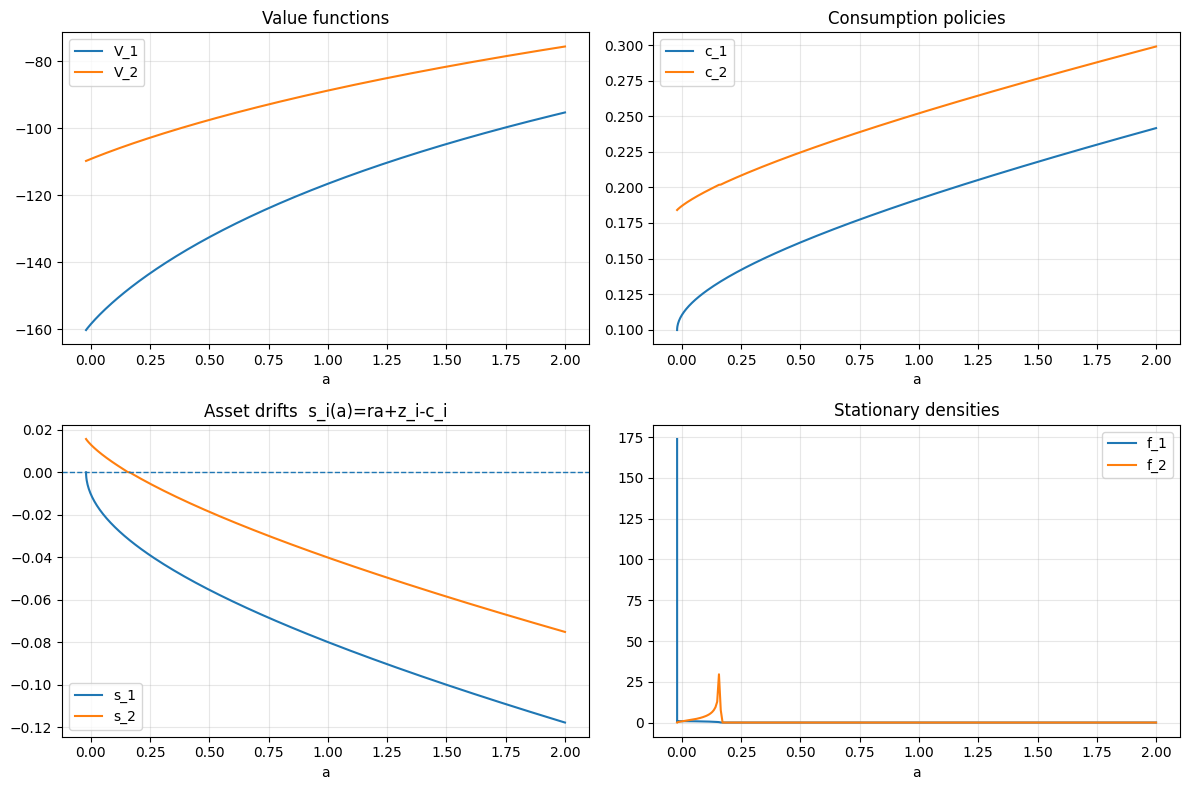

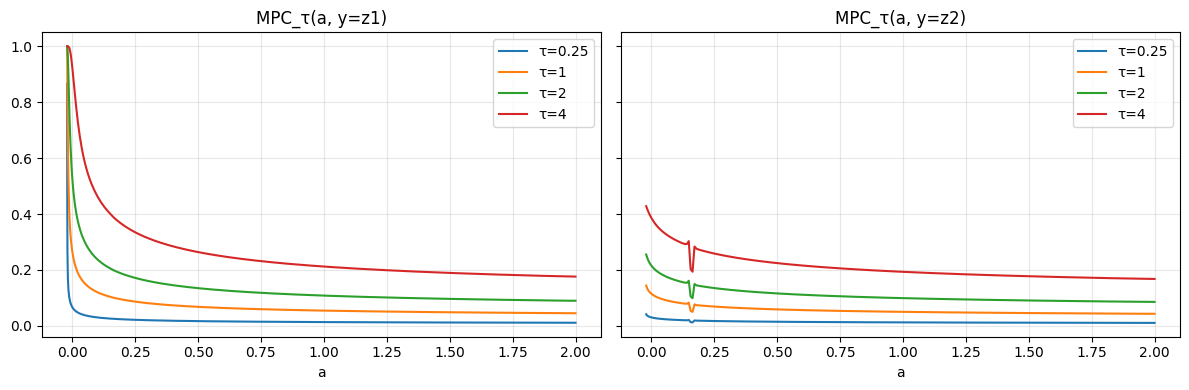

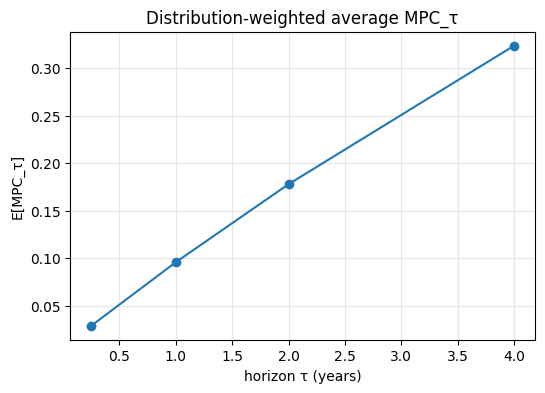

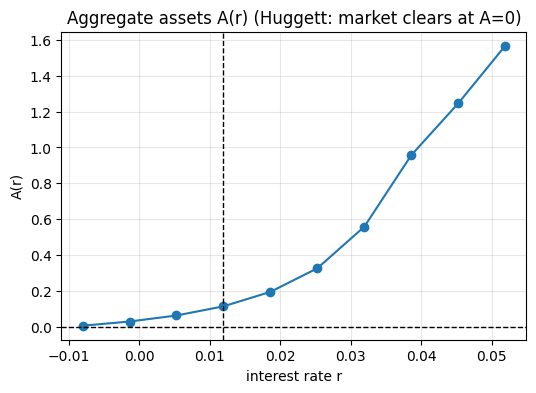


Stationary KF diagnostics at r*:
  total mass: 1.0
  ||A^T f||_∞: 1.2025269411142231e-14


In [4]:
# Huggett RCE in continuous time (2-state Poisson income) + MPCs
# HJB (implicit, upwind) + KFE (A^T f = 0 with trapezoid weights) + A(r)=0
# MPCs via Feynman–Kac: 0 = c + A Γ + Γ_t, Γ(τ)=0  ⇒  MPC_τ(a,y)=∂_a Γ(a,y,0)

import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 0) Primitives & settings
# -------------------------
rho   = 0.05
z1, z2 = 0.10, 0.20     # income levels
la1, la2 = 0.02, 0.03   # switching rates: 1->2, 2->1

amin, amax = -0.02, 2.0
I = 160

sigma = 2.0            # CRRA; set to 1.0 for log
Delta = 600.0          # implicit step (large -> fast & stable)
tol   = 1e-8
maxit = 600
howard_K = 1
plot_figs = True

# -------------------------
# Utility
# -------------------------
def u(c):
    c = np.maximum(c, 1e-12)
    if abs(sigma-1.0) < 1e-14: return np.log(c)
    return (c**(1.0-sigma)-1.0)/(1.0-sigma)

def uprime(c):
    c = np.maximum(c, 1e-12)
    if abs(sigma-1.0) < 1e-14: return 1.0/c
    return c**(-sigma)

def inv_uprime(x):
    x = np.maximum(x, 1e-12)
    if abs(sigma-1.0) < 1e-14: return 1.0/x
    return x**(-1.0/sigma)

Va_floor = 1e-5  # small slope floor

# -------------------------
# 1) Grid & weights (non-uniform; denser near amin)
# -------------------------
def make_grid(I, amin, amax, power=2.0):
    g = np.linspace(0.0, 1.0, I)
    a = amin + (g**power) * (amax - amin)
    da_f = np.empty(I)  # Δa_{i+1}
    da_b = np.empty(I)  # Δa_i
    da_f[:-1] = a[1:] - a[:-1]; da_f[-1]  = da_f[-2]
    da_b[1:]  = a[1:] - a[:-1]; da_b[0]   = da_b[1]
    return a, da_f, da_b

def trapz_weights(a):
    # node-centered trapezoid weights (non-uniform)
    w = np.empty_like(a)
    w[0]      = 0.5 * (a[1]-a[0])
    w[1:-1]   = 0.5 * (a[2:] - a[:-2])
    w[-1]     = 0.5 * (a[-1]-a[-2])
    return w

a, da_f, da_b = make_grid(I, amin, amax, power=2.0)
W = trapz_weights(a)

# -------------------------
# 2) HJB building blocks
# -------------------------
def one_sided_slopes_two(V1, V2, inc1, inc2, da_f, da_b):
    """Forward/backward slopes per state with boundary derivatives set analytically."""
    I = len(V1)
    VaF1 = np.empty(I); VaB1 = np.empty(I)
    VaF2 = np.empty(I); VaB2 = np.empty(I)
    # forward interior + top boundary
    VaF1[:-1] = (V1[1:] - V1[:-1]) / da_f[:-1]; VaF1[-1] = uprime(inc1[-1])
    VaF2[:-1] = (V2[1:] - V2[:-1]) / da_f[:-1]; VaF2[-1] = uprime(inc2[-1])
    # backward interior + bottom boundary
    VaB1[1:]  = (V1[1:] - V1[:-1]) / da_b[1:];  VaB1[0]  = uprime(inc1[0])
    VaB2[1:]  = (V2[1:] - V2[:-1]) / da_b[1:];  VaB2[0]  = uprime(inc2[0])
    return VaF1, VaB1, VaF2, VaB2

def assemble_policy_and_A_two(V1, V2, r, z1, z2, a, da_f, da_b):
    """Upwind per state; tri-diagonal per state; add switching block."""
    I = len(a)
    inc1 = r*a + z1
    inc2 = r*a + z2
    VaF1, VaB1, VaF2, VaB2 = one_sided_slopes_two(V1, V2, inc1, inc2, da_f, da_b)

    # candidates & drifts
    cF1 = inv_uprime(np.maximum(VaF1, Va_floor)); cB1 = inv_uprime(np.maximum(VaB1, Va_floor))
    cF2 = inv_uprime(np.maximum(VaF2, Va_floor)); cB2 = inv_uprime(np.maximum(VaB2, Va_floor))
    sF1 = inc1 - cF1; sB1 = inc1 - cB1
    sF2 = inc2 - cF2; sB2 = inc2 - cB2

    # MATLAB-style upwind selectors
    If1 = (sF1 > 0)
    Ib1 = (sB1 < 0) & (~If1)
    I01 = ~(If1 | Ib1)

    If2 = (sF2 > 0)
    Ib2 = (sB2 < 0) & (~If2)
    I02 = ~(If2 | Ib2)

    # policies
    c1 = np.empty(I); c1[If1]=cF1[If1]; c1[Ib1]=cB1[Ib1]; c1[I01]=inc1[I01]
    c2 = np.empty(I); c2[If2]=cF2[If2]; c2[Ib2]=cB2[Ib2]; c2[I02]=inc2[I02]

    # per-state A via s^+, s^- ; zero boundary rates in A
    sF1_pos = np.maximum(sF1, 0.0).copy()
    sB1_neg = np.minimum(sB1, 0.0).copy()
    sF2_pos = np.maximum(sF2, 0.0).copy()
    sB2_neg = np.minimum(sB2, 0.0).copy()
    sB1_neg[0]  = 0.0; sF1_pos[-1] = 0.0
    sB2_neg[0]  = 0.0; sF2_pos[-1] = 0.0

    A1 = np.zeros((I, I)); A2 = np.zeros((I, I))
    for i in range(I):
        if i > 0:
            A1[i, i-1] = (-sB1_neg[i]) / da_b[i]
            A2[i, i-1] = (-sB2_neg[i]) / da_b[i]
        if i < I-1:
            A1[i, i+1] = ( sF1_pos[i]) / da_f[i]
            A2[i, i+1] = ( sF2_pos[i]) / da_f[i]
        A1[i, i] = - ((A1[i, i-1] if i>0 else 0.0) + (A1[i, i+1] if i<I-1 else 0.0))
        A2[i, i] = - ((A2[i, i-1] if i>0 else 0.0) + (A2[i, i+1] if i<I-1 else 0.0))

    # switching block (rows sum to 0)
    Aswitch = np.block([
        [-la1*np.eye(I),  la1*np.eye(I)],
        [ la2*np.eye(I), -la2*np.eye(I)]
    ])

    # full A
    Ablk = np.block([[A1, np.zeros((I,I))],[np.zeros((I,I)), A2]]) + Aswitch
    return Ablk, (c1, c2), (sF1, sB1, sF2, sB2), (If1, Ib1, I01, If2, Ib2, I02)

def implicit_step_block(Vstack, Ablk, c1, c2, rho, Delta):
    I2 = Vstack.size
    Iden = np.eye(I2)
    M = (rho + 1.0/Delta)*Iden - Ablk
    rhs = np.concatenate([u(c1), u(c2)]) + (1.0/Delta)*Vstack
    return np.linalg.solve(M, rhs)

# -------------------------
# 3) KFE: stationary density
# -------------------------
def stationary_density(Ablk, W):
    """
    Solve A^T f = 0 with normalization sum_i f_i w_i = 1 (weights duplicated across states).
    """
    I2 = Ablk.shape[0]
    w_full = np.concatenate([W, W])
    AT = Ablk.T.copy()
    b  = np.zeros(I2)
    # replace one row with normalization
    AT[-1, :] = w_full
    b[-1] = 1.0
    f = np.linalg.solve(AT, b)
    f = np.maximum(f, 0.0)
    mass = float(w_full @ f)
    f /= mass if mass > 0 else 1.0
    return f[:I], f[I:]

# -------------------------
# 4) Solve HJB+KFE for a given r, return A(r)
# -------------------------
def solve_hjb_kfe_given_r(r, verbose=False):
    inc1 = r*a + z1
    inc2 = r*a + z2
    # initialization: zero-drift value
    V1 = u(inc1)/rho
    V2 = u(inc2)/rho

    for it in range(maxit):
        Ablk, (c1, c2), (sF1, sB1, sF2, sB2), flags = assemble_policy_and_A_two(V1, V2, r, z1, z2, a, da_f, da_b)
        V_old1, V_old2 = V1.copy(), V2.copy()
        Vstack = np.concatenate([V1, V2])
        for _ in range(howard_K):
            Vstack = implicit_step_block(Vstack, Ablk, c1, c2, rho, Delta)
        V1, V2 = Vstack[:I], Vstack[I:]
        if max(np.max(np.abs(V1-V_old1)), np.max(np.abs(V2-V_old2))) < tol:
            break

    # stationary density
    f1, f2 = stationary_density(Ablk, W)
    # aggregate assets
    AggA = float((W*a) @ f1 + (W*a) @ f2)

    if verbose:
        print(f"[r={r:.5f}] it={it+1}, A(r)={AggA:.6g}")
    return {
        "r": r, "A": AggA,
        "Ablk": Ablk, "V1": V1, "V2": V2, "c1": c1, "c2": c2,
        "s1": (r*a + z1) - c1, "s2": (r*a + z2) - c2,
        "f1": f1, "f2": f2, "flags": flags
    }

# -------------------------
# 5) Find equilibrium r* (Huggett: A(r*) = 0)
# -------------------------
def bracket_root(f, grid):
    vals = [f(r)["A"] for r in grid]
    for i in range(len(grid)-1):
        if vals[i] == 0.0:
            return grid[i], grid[i]
        if vals[i]*vals[i+1] < 0:
            return grid[i], grid[i+1]
    # fallback: no sign change; pick closest pair
    k = int(np.argmin(np.abs(vals)))
    kk = np.argsort(np.abs(vals))[1] if len(vals)>1 else k
    return grid[min(k,kk)], grid[max(k,kk)]

def bisection_on_r(r_lo, r_hi, f, tol_r=1e-6, maxit=50, verbose=True):
    A_lo = f(r_lo)["A"]; A_hi = f(r_hi)["A"]
    if verbose: print(f"Initial bracket: r in [{r_lo:.6f},{r_hi:.6f}], A=[{A_lo:.6g},{A_hi:.6g}]")
    for it in range(maxit):
        r_mid = 0.5*(r_lo + r_hi)
        out = f(r_mid)
        A_mid = out["A"]
        if verbose: print(f"  it={it+1:02d}: r_mid={r_mid:.8f}, A={A_mid:.6g}")
        if abs(A_mid) < 1e-10 or abs(r_hi - r_lo) < tol_r:
            out["r_star"] = r_mid
            return out
        if A_lo * A_mid <= 0:
            r_hi, A_hi = r_mid, A_mid
        else:
            r_lo, A_lo = r_mid, A_mid
    out["r_star"] = r_mid
    return out

# coarse scan to get a bracket
r_grid_scan = np.linspace(0.01, 0.2, 100)  # adjust if needed
r_lo, r_hi = bracket_root(lambda rr: solve_hjb_kfe_given_r(rr, verbose=False), r_grid_scan)

# bisection to solve A(r)=0
eq = bisection_on_r(r_lo, r_hi, lambda rr: solve_hjb_kfe_given_r(rr, verbose=False), tol_r=5e-7, maxit=40, verbose=True)
r_star = eq["r_star"]

print("\n=== Huggett equilibrium ===")
print(f"r* = {r_star:.8f}")
print(f"A(r*) ≈ {eq['A']:.6g}")

# unpack equilibrium objects
V1, V2 = eq["V1"], eq["V2"]
c1, c2 = eq["c1"], eq["c2"]
s1, s2 = eq["s1"], eq["s2"]
f1, f2 = eq["f1"], eq["f2"]
Ablk = eq["Ablk"]

# -------------------------
# 6) MPCs via Feynman–Kac: Γ backward in time
# -------------------------
def Gamma_at_zero(Ablk, c1, c2, tau, nsteps=300):
    """
    Solve 0 = c + A Γ + Γ_t backward, Γ(τ)=0.
    Return Γ(0) split by state.
    """
    I2 = 2*I
    dt = tau / nsteps
    M = (np.eye(I2)/dt) - Ablk               # constant over time
    rhs_c = np.concatenate([c1, c2])

    Gamma_next = np.zeros(I2)
    for _ in range(nsteps):
        rhs = rhs_c + Gamma_next/dt
        Gamma_now = np.linalg.solve(M, rhs)
        Gamma_next = Gamma_now
    G = Gamma_next
    return G[:I], G[I:]

def mpc_from_Gamma(G1, G2, a):
    """
    MPC_tau(a,y) = ∂_a Γ(a,y,0). Use non-uniform central differences (one-sided on boundaries).
    """
    I = len(a)
    m1 = np.empty(I); m2 = np.empty(I)
    # state 1
    m1[0]  = (G1[1]-G1[0]) / (a[1]-a[0])
    m1[-1] = (G1[-1]-G1[-2]) / (a[-1]-a[-2])
    m1[1:-1] = (G1[2:]-G1[:-2]) / (a[2:]-a[:-2])
    # state 2
    m2[0]  = (G2[1]-G2[0]) / (a[1]-a[0])
    m2[-1] = (G2[-1]-G2[-2]) / (a[-1]-a[-2])
    m2[1:-1] = (G2[2:]-G2[:-2]) / (a[2:]-a[:-2])
    return m1, m2

def average_mpc(m1, m2, f1, f2, W):
    """Distribution-weighted average MPC."""
    return float((W*m1)@f1 + (W*m2)@f2)

# choose MPC horizons (in years)
tau_list = [0.25, 1.0, 2.0, 4.0]   # quarter, 1y, 2y, 4y
mpc_curves = {}
E_mpc = []
for tau in tau_list:
    G1, G2 = Gamma_at_zero(Ablk, c1, c2, tau, nsteps=300)
    m1_tau, m2_tau = mpc_from_Gamma(G1, G2, a)
    mpc_curves[tau] = (m1_tau, m2_tau)
    E_mpc.append( average_mpc(m1_tau, m2_tau, f1, f2, W) )

E_mpc = np.array(E_mpc)

print("\nMPCs (distribution-weighted averages):")
for tau, Em in zip(tau_list, E_mpc):
    print(f"  tau={tau:>5.2f}  E[MPC_tau] = {Em:.4f}")

# -------------------------
# 7) Plot objects in equilibrium + MPCs
# -------------------------
if plot_figs:
    # Value, c, s, densities
    fig, axs = plt.subplots(2,2, figsize=(12,8))
    axs[0,0].plot(a, V1, label='V_1'); axs[0,0].plot(a, V2, label='V_2')
    axs[0,0].set_title("Value functions"); axs[0,0].set_xlabel("a"); axs[0,0].legend(); axs[0,0].grid(alpha=0.3)

    axs[0,1].plot(a, c1, label='c_1'); axs[0,1].plot(a, c2, label='c_2')
    axs[0,1].set_title("Consumption policies"); axs[0,1].set_xlabel("a"); axs[0,1].legend(); axs[0,1].grid(alpha=0.3)

    axs[1,0].plot(a, s1, label='s_1'); axs[1,0].plot(a, s2, label='s_2'); axs[1,0].axhline(0, ls='--', lw=1)
    axs[1,0].set_title("Asset drifts  s_i(a)=ra+z_i-c_i"); axs[1,0].set_xlabel("a"); axs[1,0].legend(); axs[1,0].grid(alpha=0.3)

    axs[1,1].plot(a, f1, label='f_1'); axs[1,1].plot(a, f2, label='f_2')
    axs[1,1].set_title("Stationary densities"); axs[1,1].set_xlabel("a"); axs[1,1].legend(); axs[1,1].grid(alpha=0.3)
    plt.tight_layout(); plt.show()

    # MPC vs assets for each state, multiple horizons
    fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
    for tau in tau_list:
        m1_tau, m2_tau = mpc_curves[tau]
        axs[0].plot(a, m1_tau, label=f'τ={tau:g}')
        axs[1].plot(a, m2_tau, label=f'τ={tau:g}')
    axs[0].set_title("MPC_τ(a, y=z1)"); axs[0].set_xlabel("a"); axs[0].grid(alpha=0.3); axs[0].legend()
    axs[1].set_title("MPC_τ(a, y=z2)"); axs[1].set_xlabel("a"); axs[1].grid(alpha=0.3); axs[1].legend()
    plt.tight_layout(); plt.show()

    # Average MPC as function of tau
    plt.figure(figsize=(6,4))
    plt.plot(tau_list, E_mpc, marker='o')
    plt.title("Distribution-weighted average MPC_τ")
    plt.xlabel("horizon τ (years)"); plt.ylabel("E[MPC_τ]")
    plt.grid(alpha=0.3); plt.show()

# -------------------------
# 8) Asset supply curve A(r)
# -------------------------
# Build a smooth curve around r*
r_span = np.linspace(max(r_star-0.02, -0.02), r_star+0.04, 10)
A_vals = []
for rr in r_span:
    out = solve_hjb_kfe_given_r(rr, verbose=False)
    A_vals.append(out["A"])
A_vals = np.array(A_vals)

if plot_figs:
    plt.figure(figsize=(6,4))
    plt.plot(r_span, A_vals, marker='o')
    plt.axhline(0, ls='--', lw=1, color='k')
    plt.axvline(r_star, ls='--', lw=1, color='k')
    plt.title("Aggregate assets A(r) (Huggett: market clears at A=0)")
    plt.xlabel("interest rate r"); plt.ylabel("A(r)")
    plt.grid(alpha=0.3)
    plt.show()

# -------------------------
# 9) KF diagnostics
# -------------------------
Wfull = np.concatenate([W,W])
AT_resid = Ablk.T @ np.concatenate([f1,f2])
print("\nStationary KF diagnostics at r*:")
print("  total mass:", float(W @ f1 + W @ f2))
print("  ||A^T f||_∞:", float(np.max(np.abs(AT_resid))))


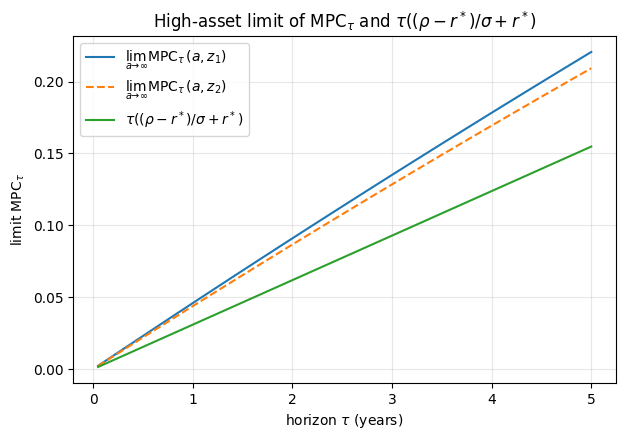

Coefficient ((rho - r*)/sigma + r*) = 0.0309595


In [6]:
# === High-asset-limit MPC vs τ * ((ρ - r*)/σ + r*) ===
# Approximates lim_{a→∞} MPC_τ(a,y) by a weighted average over the top tail of the asset grid.

# horizons to inspect
tau_grid = np.linspace(0.05, 5.0, 40)  # years

# pick tail width: use ~top 5% of grid points (at least 3)
k_top = max(3, I // 20)
idx_top = np.arange(I - k_top, I)

# precompute tail weights (normalize within the tail)
W_tail = W[idx_top]
W_tail = W_tail / W_tail.sum()

m1_inf = np.empty_like(tau_grid)
m2_inf = np.empty_like(tau_grid)

for j, tau in enumerate(tau_grid):
    # Γ(0) via backward time-stepping, then MPC = ∂a Γ
    G1, G2 = Gamma_at_zero(Ablk, c1, c2, tau, nsteps=300)
    m1_tau, m2_tau = mpc_from_Gamma(G1, G2, a)

    # weighted average over the last k_top nodes ≈ lim_{a→∞}
    m1_inf[j] = np.dot(W_tail, m1_tau[idx_top])
    m2_inf[j] = np.dot(W_tail, m2_tau[idx_top])

# comparison curve: τ * ((ρ - r*)/σ + r*)
coef = (rho - r_star)/sigma + r_star
comp_line = tau_grid * coef

plt.figure(figsize=(7,4.5))
plt.plot(tau_grid, m1_inf, label=r"$\lim_{a\to\infty}\mathrm{MPC}_\tau(a,z_1)$")
plt.plot(tau_grid, m2_inf, label=r"$\lim_{a\to\infty}\mathrm{MPC}_\tau(a,z_2)$", linestyle="--")
plt.plot(tau_grid, comp_line, label=r"$\tau((\rho - r^*)/\sigma + r^*)$", linewidth=1.5)
plt.xlabel(r"horizon $\tau$ (years)")
plt.ylabel(r"limit $\mathrm{MPC}_\tau$")
plt.title(r"High-asset limit of $\mathrm{MPC}_\tau$ and $\tau((\rho - r^*)/\sigma + r^*)$")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print(f"Coefficient ((rho - r*)/sigma + r*) = {coef:.6g}")
